In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
import theano

%matplotlib inline

Q1. Suppose the globe tossing data had turned out to be 8 water in 15 tosses.
Construct the posterior distribution, using grid approximation. Use the
same flat prior as before. 

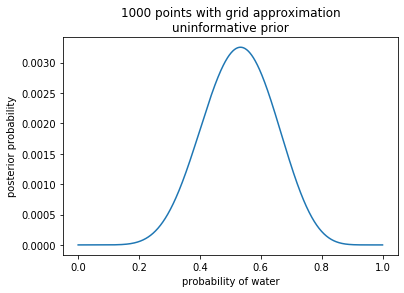

In [29]:
w, n = 8, 15
n_g = 1000
p_grid = np.linspace(0,1,n_g)
prior = np.ones(n_g)
likelihood = stats.binom.pmf(k=w, n=n, p=p_grid)
unstd_posterior = prior * likelihood
std_posterior = unstd_posterior/unstd_posterior.sum()

plt.plot(p_grid, std_posterior)
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f"{n_g} points with grid approximation\nuninformative prior")
pass

In [34]:
# sample water prob from posterior distribution
samples = np.random.choice(p_grid, size=n_g, replace=True, p=std_posterior)
print('mean = ', np.mean(samples))
print("99% percentile interval", np.percentile(samples, q=(0.5,99.5)))

mean =  0.5343223223223222
99% percentile interval [0.27627127 0.81882382]


Q2. Start over in 1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority
of the Earth’s surface is water. What difference does the better prior make?
If it helps, compare posterior distributions (using both priors) to the true
value p = 0.7.

<font color='red'>Question: truncated prior just 0 and 1 or 0 and 1/(1-truncated_threshold)</font>

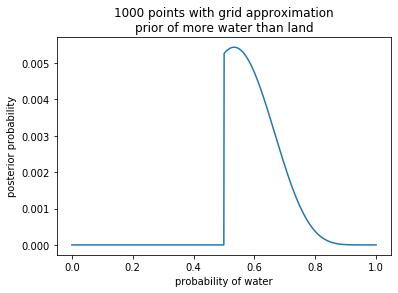

In [50]:
w, n = 8, 15
n_g = 1000
p_grid = np.linspace(0,1,n_g)

# pymc guys' verions
# prior = (p_grid > 0.5).astype(int)
# auther's verions
# prior = np.repeat((0,1), n_g/2)
# I think it should be ... in order to keep area under curve sum up ot 1
truncated_val = 0.5
prior = np.repeat((0, 1/(1-truncated_val)), n_g/2)

likelihood = stats.binom.pmf(k=w, n=n, p=p_grid)
unstd_posterior = prior * likelihood
trunc_prior_std_posterior = unstd_posterior/unstd_posterior.sum()

plt.plot(p_grid, trunc_prior_std_posterior)
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f"{n_g} points with grid approximation\nprior of more water than land")
pass

In [51]:
# sample water prob from posterior distribution
trunc_samples = np.random.choice(p_grid, size=n_g, replace=True, p=trunc_prior_std_posterior)
print('mean = ', np.mean(trunc_samples))
print("99% percentile interval", np.percentile(trunc_samples, q=(0.5,99.5)))

mean =  0.6090820820820821
99% percentile interval [0.5005005  0.82683684]


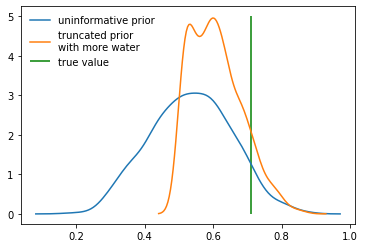

In [63]:
# compare priors
sns.kdeplot(samples, label="uninformative prior")
sns.kdeplot(trunc_samples, label="truncated prior\nwith more water")
plt.vlines(x=0.71, ymin=0, ymax=5, color='g', label='true value')
plt.legend(loc=2, frameon=False)

Q3. This problem is more open-ended than the others. Feel free to collaborate on the solution. Suppose you want to estimate the Earth’s proportion of
water very precisely. Specifically, you want the 99% percentile interval of the
posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many
times will you have to toss the globe to do this? I won’t require a precise
answer. I’m honestly more interested in your approach.

In [ ]:
np.random.seed(23)
n_samples = 500
p = np.repeat(np.nan, n_samples)
p[0] = 0.5
w, n = 6, 9
for idx in range(1, n_samples):
    p_new = np.random.normal(loc=p[idx-1], scale=0.1)
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    q_prev = stats.binom.pmf(w, n, p[idx-1])
    q_curr = stats.binom.pmf(w, n, p_new)
    
    p[idx] = p_new if q_curr/q_prev > np.random.uniform() else p[idx-1]

In [64]:
# simulation with incremental number of tosses
np.random.seed(27)

# start with 100 tosses
n_tosses = 100
# increase n_tosses by step_size
step_size = 100

# number of simulations
n_sims = 500

# desired 99% percentile width
desired_width = 0.05

# initialise width for 50 tosses, just guessing 50 is not enough
# from Q2. 1 observation only with n_tosses = 15 and width = 0.33
current_width = 0.8

# the width of percentile, at least for binomial, only depends on the standard deviation, not the mean
# for binomial, mean = np, variance = np(1-p)
# set a fixed p
p = 0.71

def beta_99ppf(k, n):
    return stats.beta.ppf([0.005, 0.995], a=k+1, b=n-k+1)

width_cache = {"n_tosses":[], "width":[]}
while current_width > desired_width:
    n_tosses = n_tosses + step_size
    
    n_water = np.random.binomial(n_tosses, p, size=n_sims)
    perc99 = np.array([beta_99ppf(w, n_tosses) for w in n_water])
    current_width = np.average(perc99[:,1] - perc99[:,0])
    width_cache['n_tosses'].append(n_tosses)
    width_cache['width'].append(current_width)
    
    if n_tosses % 500:
        print(f"{n_tosses} tosses, width = {current_width}")
    # dont want it to run forever; if more than threshold, stop and adjust initial n_tosses
    if n_tosses == 1e4:
        break
        
print('\nFound it!')
print(f"{n_tosses} tosses, width = {current_width}")
print("99% percentile is", (np.average(perc99[:,0]),np.average(perc99[:,1])))

200 tosses, width = 0.1636832187196799
300 tosses, width = 0.13367807648629546
400 tosses, width = 0.11605914207695606
600 tosses, width = 0.09498616112567569
700 tosses, width = 0.08812363767343476
800 tosses, width = 0.08238910343861942
900 tosses, width = 0.07759131649698688
1100 tosses, width = 0.07027396109199867
1200 tosses, width = 0.06730657199446435
1300 tosses, width = 0.06474294601403108
1400 tosses, width = 0.06238705448447859
1600 tosses, width = 0.058304604333400775
1700 tosses, width = 0.05661820876158487
1800 tosses, width = 0.0550369838965243
1900 tosses, width = 0.053552996942587784
2100 tosses, width = 0.05096404121704465
2200 tosses, width = 0.04974863294192427

Found it!
2200 tosses, width = 0.04974863294192427
99% percentile is (0.685193740620524, 0.7349423735624483)


Text(0.5, 1.0, 'width of 99% percentile\naverage over 500 simulation runs')

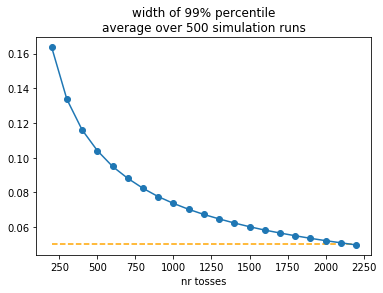

In [74]:
plt.plot(width_cache['n_tosses'], width_cache['width'], 'o-')
plt.hlines(0.05, xmin=width_cache['n_tosses'][0], xmax=width_cache['n_tosses'][-1],
          colors='orange',linestyles='dashed')
plt.xlabel("nr tosses")
plt.title(f"width of 99% percentile\naverage over {n_sims} simulation runs")